I am running pixy (for fst, pi, dxy) in a couple of different ways to get an idea of whether nucleotide diversity / divergence and fixation are different at TRD loci than elsewhere.

In [1]:
stop("Filename shouzld be after 02_VCF_SV and 02_Local-Phylogeny as those needs to be done first")

ERROR: Error in eval(expr, envir, enclos): Filename shouzld be after 02_VCF_SV and 02_Local-Phylogeny as those needs to be done first


I should be able to get all sites vcf with <https://pixy.readthedocs.io/en/latest/generating_invar/generating_invar.html#generating-allsites-vcfs-using-gatk> and `~/data/trd/GVCF_2489Strains/`

In [1]:
source("../../BrusselSprouts/scripts/functions.R")
scripts_dir="/home/jnrunge/data/trd/mapped_reads/scripts/"
initial_timedate=Sys.time()
library(tidytable)

Warning message:
"package 'data.table' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'naturalsort' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'tidytable' was built under R version 4.1.3"
This can lead to most dplyr functions being overwritten by tidytable functions.


Attaching package: 'tidytable'


The following objects are masked from 'package:dplyr':

    across, add_count, add_tally, anti_join, arrange, between,
    bind_cols, bind_rows, c_across, case_match, case_whe

In [2]:
# code from 02_Local-Ph...
# prepare for IBS calculations

library(SNPRelate)
library(ape)

# Get paths of input files
my.vcf <- "/home/jnrunge/data/trd/full2489Matrix.vcf.gz"
subset_samples = "none"

if(subset_samples == "none"){
    subset_samples=NULL
    prefix <- basename(my.vcf)
    }else{
    prefix <- basename(subset_samples)
    subset_samples=readLines(subset_samples)
    }

#setwd(dirname(my.vcf))
if(!file.exists(paste0(dirname(my.vcf), "/", prefix, ".gds"))){
    snpgdsVCF2GDS(my.vcf, paste0(prefix, ".gds"), ignore.chr.prefix="chromosome")
}

genofile <- snpgdsOpen(paste0(dirname(my.vcf), "/", prefix, ".gds"))

Warning message:
"package 'SNPRelate' was built under R version 4.1.3"
Loading required package: gdsfmt

Warning message:
"package 'gdsfmt' was built under R version 4.1.3"
SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)

Warning message:
"package 'ape' was built under R version 4.1.3"

Attaching package: 'ape'


The following object is masked from 'package:tidytable':

    where


The following object is masked from 'package:dplyr':

    where




In [3]:
# make sample name map  samplename\tgvcf

samples=list.files("/home/jnrunge/data/trd/GVCF_2489Strains", "g.vcf.gz$", full.names = TRUE)
samples=data.frame(id=unlist(lapply(basename(samples), getFirst_v2, split=".")),file=samples)
fwrite(samples, "~/data/trd/mapped_reads/truly_all_samples.tsv", col.names = FALSE, sep="\t")

In [4]:
if(!file.exists("~/data/trd/mapped_reads/ALL.DP5-95.chromosome1.DP10.GQ20RGQ20.SNPsRef.vcf.gz")){ # just an example, so that keeping the filtered files on the server is enough
    # unfiltered files are on viseg
    file.create(running_file<-paste0("~/data/TRD/runningGATKFullmerge"))
    cmd="cd ~/data/trd/mapped_reads"# && rm -rf ALL_DB"
    cmd=paste0(cmd, " && gatk GenomicsDBImport --batch-size 200 --genomicsdb-workspace-path ALL_DB --sample-name-map ~/data/trd/mapped_reads/truly_all_samples.tsv -L ~/data/TRD/R64_nucl.fasta.fai.bed")
    cmd=paste0(cmd, " && gatk GenotypeGVCFs --java-options '-Xmx180G' -R ../../TRD/R64_nucl.fasta -all-sites -V gendb://ALL_DB -O ALL.vcf.gz")
    cmd=paste0(cmd, " && bcftools query -l ALL.vcf.gz > ALL.vcf.gz.samples && bcftools view -Ob -o ALL.bcf ALL.vcf.gz && rm -f ~/data/TRD/runningGATKFullmerge")
    execute_cmd_sbatch(cmd, mem="200G", cpu="1", time="long", env="bwaetc", jobname="GATK_merge")

    while(file.exists(running_file)){
        Sys.sleep(60)
    }
}

Now I need to filter and do this carefully. We want to remove indels and low GQ calls. invariant sites have "RGQ" instead of GQ, which is the chance of a wrong call, so here we also want a high number (unlike PL). 

So we want GQ >= 20 or RGQ >= 20 I would think. 

First, we get an overview of the average DP in total, and which positions should be removed because they are outside the 5%-95% range

````bash
bcftools query -f "%CHROM\t%POS\t%INFO/DP\n" ALL.vcf.gz | gzip > ALL.vcf.gz.DP.gz
````


````r
DP=fread("~/data/trd/mapped_reads/ALL.vcf.gz.DP.gz")

print(quantile(as.numeric(DP$V3), c(0.05,0.95), na.rm = TRUE))
````

````bash

# sites filtering depth
bcftools view -i "INFO/DP >= 149240 & INFO/DP <= 408636" -Ob -o ALL.DP5-95.bcf ALL.vcf.gz

bcftools index ALL.DP5-95.bcf

bcftools view ALL.DP5-95.bcf | grep -v ^# | cut -f 1 | uniq > chrs.txt


````

In [5]:
chrs=readLines("~/data/trd/mapped_reads/chrs.txt") # its just a list of chromosomes (see MD block above)
for(c in chrs){
    if(file.exists(paste0("~/data/trd/mapped_reads/ALL.DP5-95.",c,".DP10.GQ20RGQ20.SNPsRef.vcf.gz"))){
        next
    }
    # filtering VCF and splitting into chromosomes
    cmd=paste0('sh -xe ~/TRD/03_GenomicSignals/01_pixy_filter-vcf.sh ',c)
    execute_cmd_sbatch(cmd, mem="8G", cpu="1", time="long", env="bwaetc", jobname="bcftools_filter")
    Sys.sleep(1)
}

In [6]:
samples=readLines("~/data/trd/mapped_reads/ALL.vcf.gz.samples")

In [7]:
# what groups should be run?
pop_files=list()


# each pop
pops=fread("../Shiny/data/Victor/operationalTable_Full2543Sace_Clades.csv")
summary(samples%in%pops$StandardizedName)
popList=left_join(data.table(Strain=samples), select(pops, StandardizedName, Clade), by=c("Strain"="StandardizedName"))
popList=filter(popList, !is.na(Clade))
popList=mutate(popList, Clade=gsub("[ .]","_",Clade))
head(popList)
fwrite(popList, pop_files[["Clades"]]<-"~/data/trd/mapped_reads/ALL.vcf.gz-Clades.popList", sep="\t", col.names = FALSE)

   Mode    TRUE 
logical    2489 

Strain,Clade
<chr>,<chr>
AAA,1__Wine
AAB,8__Belgium_Beer
AAC,10__UK_Beer
AAD,18__Asian_Fermentation
AAE,1__Wine
AAG,16__USA_Clinical_1


In [8]:
selectSimilarities=c(0.98,0.985,0.9,0.995) # changed from 0.7, which was based on another calculation method
df_Strains=fread("../Shiny/data/Victor/operationalTable_Full2543Sace_Clades.csv")

crosses=readLines("~/data/trd/mapped_reads/TRD.vcf.gz.samples")
crosses=crosses[startsWith(crosses, "YJNRC") | startsWith(crosses, "Chris")]
crosses

[1] "ChrisC1" "ChrisC2" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC6" "ChrisC7"
 [8] "ChrisC8" "YJNRC1"  "YJNRC11" "YJNRC12" "YJNRC14" "YJNRC15" "YJNRC16"
[15] "YJNRC17" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21" "YJNRC22"
[22] "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29" "YJNRC3" 
[29] "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC34" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[36] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [9]:
source("../LoadCrosses.r")

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


In [10]:

# add TRD-similar strains vs rest

similarity_number_of_samples<-data.table()

for(c in crosses){
    if(!file.exists(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))){
        print("skip1")
        next
    }
    if(file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz")) < file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))){
        print("skip2")
        next
    }
    if(file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))<file.mtime(paste0("/home/jnrunge/data/trd/mapped_reads/TRD.vcf.gz"))){
        print("skip3")
        next
    }
    # AS=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))

    TRD=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
    if(!file.exists(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))){
        print("skip4")
        next
    }

    TRD_loci=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))
    
    for(i in 1:nrow(TRD_loci)){
        if(TRD_loci$chr_start[i]!=TRD_loci$chr_end[i]){
        stop("chr overlapping TRD")
    }
        TRD_subset=filter(TRD, chr== TRD_loci$chr_start[i] & global_pos >= TRD_loci$global_start[i] & global_pos <= TRD_loci$global_end[i])
        TRD_subset_from<-min(pull(TRD_subset, pos))
        TRD_subset_to<-max(pull(TRD_subset, pos))
        if(is.na(TRD_subset_from)|is.na(TRD_subset_to)){
            stop("Error in data")
        }
        # calculate IBS matrix
        snpset=which(read.gdsn(index.gdsn(genofile, "snp.position"))>=TRD_subset_from&
                     read.gdsn(index.gdsn(genofile, "snp.position"))<=TRD_subset_to&
                     read.gdsn(index.gdsn(genofile, "snp.chromosome"))==TRD_loci$chr_start[i]%>%str_replace("chromosome",""))
        if(length(snpset)==0){
            stop("No SNPs??")
        }
        if(!file.exists(paste0("~/data/trd/mapped_reads/ALL.vcf.gz-",paste0("TRD_",c,"_",i),".IBS.RDS")) || 
          file.mtime(paste0("~/data/trd/mapped_reads/ALL.vcf.gz-",paste0("TRD_",c,"_",i),".IBS.RDS"))<file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))){
            ibs_trd <- snpgdsIBS(genofile, num.thread=1, snp.id = snpset)
            saveRDS(ibs_trd, paste0("~/data/trd/mapped_reads/ALL.vcf.gz-",paste0("TRD_",c,"_",i),".IBS.RDS"))
        }else{
            ibs_trd <- readRDS(paste0("~/data/trd/mapped_reads/ALL.vcf.gz-",paste0("TRD_",c,"_",i),".IBS.RDS"))
        }
        
        
        crosses_all_slice<-filter(crosses_all, `Cross ID` == c)
        strain_1<-pull(crosses_all_slice, `Short name 1`)
        strain_2<-pull(crosses_all_slice, `Short name 2`)
        
        id1<-which(read.gdsn(index.gdsn(genofile, "sample.id"))==strain_1)
        id2<-which(read.gdsn(index.gdsn(genofile, "sample.id"))==strain_2)
        
        id1_ibs<-ibs_trd$ibs[id1,]
        id2_ibs<-ibs_trd$ibs[id2,]
        
        for(selectSimilarity in selectSimilarities)
            {

            id1_ibs_similar<-read.gdsn(index.gdsn(genofile, "sample.id"))[id1_ibs>=selectSimilarity]
            id2_ibs_similar<-read.gdsn(index.gdsn(genofile, "sample.id"))[id2_ibs>=selectSimilarity]

            # df_AS_filtered=filter(AS, `#CHROM` == TRD_loci$chr_start[i], POS %in% TRD_subset$pos)
    #         melted=reshape2::melt(df_AS_filtered, id.vars = c("#CHROM","POS"))
    #         melted=filter(melted, variable != "chrpos")
    #         tmp=summarise(group_by(melted, variable), nAll=n())
    #         vcf_translated_summary=left_join(tmp,summarise(group_by(melted, variable, value), n=n()), by=c("variable"))%>%mutate(p=n/nAll)%>%select(variable,value,p)%>%rename(Strain=variable, Type=value)
    #         A1s=vcf_translated_summary$Strain[vcf_translated_summary$Type=="A1_hom" & vcf_translated_summary$p>=selectSimilarity]
    #         A2s=vcf_translated_summary$Strain[vcf_translated_summary$Type=="A2_hom" & vcf_translated_summary$p>=selectSimilarity]


    #         strain_summary=bind_rows(summarise(group_by(filter(df_Strains, StandardizedName %in% A1s),
    #                        StandardizedName), n=n()) %>% arrange(-n)%>%mutate(Type="A1_hom"),
    #               summarise(group_by(filter(df_Strains, StandardizedName %in% A2s),
    #                                  StandardizedName), n=n()) %>% arrange(-n)%>%mutate(Type="A2_hom"))%>% arrange(-n)

            if(mean(TRD_subset$AD_A1/TRD_subset$sumCount)<0.5){
             #distorter="A2"
             #nondistorter="A1"
             distorter_like_samples<-id2_ibs_similar
             for(sim in seq(from=0.98, to=1, by=0.001)){
                 # statisttics to figure out a good sim value
                 similarity_number_of_samples<-bind_rows(similarity_number_of_samples,data.table(similarity=sim, cross=c, row=i, 
                                                                   num_samples_similar_to_distorter=sum(id2_ibs>=sim)))
             }
        }else{
             #distorter="A1"
             #nondistorter="A2"
             distorter_like_samples<-id1_ibs_similar
                for(sim in seq(from=0.98, to=1, by=0.001)){
                 # statisttics to figure out a good sim value
                 similarity_number_of_samples<-bind_rows(similarity_number_of_samples,data.table(similarity=sim, cross=c, row=i, 
                                                                   num_samples_similar_to_distorter=sum(id1_ibs>=sim)))
             }
            }

            pop_list_trd=data.frame(sample=samples,pop="other",stringsAsFactors = FALSE)
            pop_list_trd$pop[pop_list_trd$sample%in%distorter_like_samples]="distorter-like"


            fwrite(pop_list_trd, pop_files[[paste0("TRD_",c,"_",slice(TRD_loci, i)%>%pull(ID),"_",selectSimilarity)]]<-paste0("~/data/trd/mapped_reads/ALL.vcf.gz-",paste0("TRD_",c,"_",i,"_",selectSimilarity),".popList"), sep="\t", col.names = FALSE)
        }
        # also calculate between just the parents
        
        pop_list_trd_parents<-data.table(sample=c(strain_1, strain_2), pop=c(strain_1,strain_2))
        
        fwrite(pop_list_trd_parents, pop_files[[paste0("TRD_",c,"_",slice(TRD_loci, i)%>%pull(ID),"_justparents")]]<-paste0("~/data/trd/mapped_reads/ALL.vcf.gz-",paste0("TRD_",c,"_",i,"_justparents"),".popList"), sep="\t", col.names = FALSE)
    }
}






[1] "skip4"
[1] "skip4"
[1] "skip4"
[1] "skip4"
[1] "skip4"
[1] "skip4"


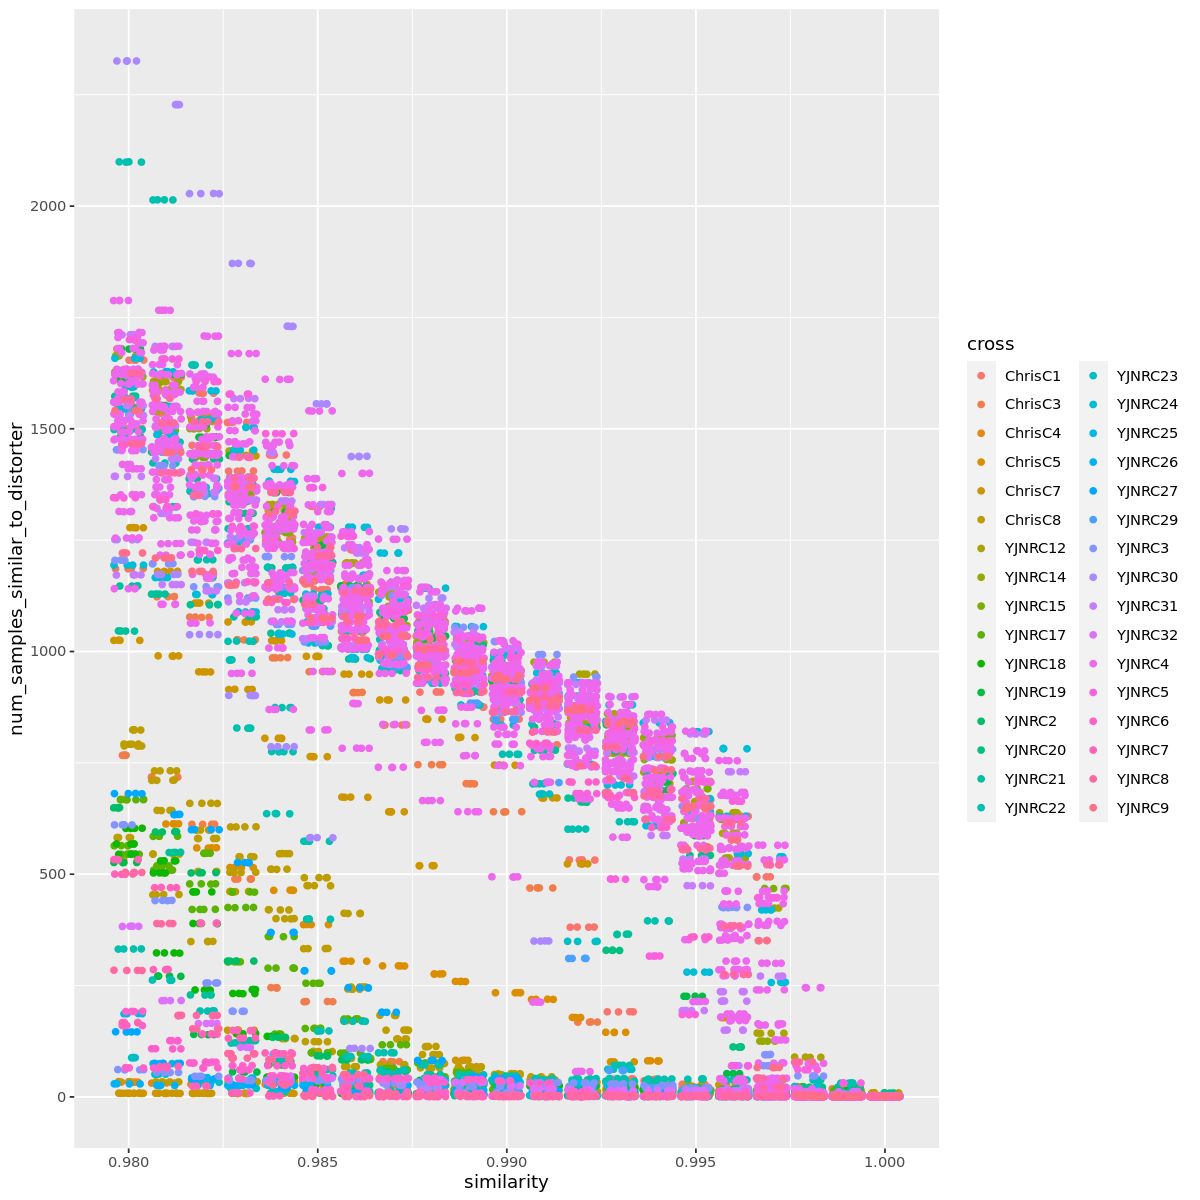

In [11]:
ggplot(similarity_number_of_samples, aes(similarity, num_samples_similar_to_distorter, color=cross))+
geom_jitter()

In [12]:
group_by(similarity_number_of_samples, similarity)%>%summarize(pGr1=sum(num_samples_similar_to_distorter>1)/n(),
                                                              pGr10=sum(num_samples_similar_to_distorter>10)/n(),
                                                              median=median(num_samples_similar_to_distorter))

similarity,pGr1,pGr10,median
<dbl>,<dbl>,<dbl>,<dbl>
0.980,1.00000000,0.9745763,1471.0
0.981,1.00000000,0.9745763,1393.5
0.982,1.00000000,0.9745763,1299.5
0.983,1.00000000,0.9661017,1220.5
0.984,1.00000000,0.9661017,1144.0
0.985,0.99152542,0.9491525,1078.5
0.986,0.98305085,0.9322034,1036.0
0.987,0.97457627,0.8898305,990.5
0.988,0.97457627,0.8728814,957.5


In [13]:
names(pop_files)

[1] "Clades"                     "TRD_ChrisC1_1_0.98"        
  [3] "TRD_ChrisC1_1_0.985"        "TRD_ChrisC1_1_0.9"         
  [5] "TRD_ChrisC1_1_0.995"        "TRD_ChrisC1_1_justparents" 
  [7] "TRD_ChrisC1_9_0.98"         "TRD_ChrisC1_9_0.985"       
  [9] "TRD_ChrisC1_9_0.9"          "TRD_ChrisC1_9_0.995"       
 [11] "TRD_ChrisC1_9_justparents"  "TRD_ChrisC1_13_0.98"       
 [13] "TRD_ChrisC1_13_0.985"       "TRD_ChrisC1_13_0.9"        
 [15] "TRD_ChrisC1_13_0.995"       "TRD_ChrisC1_13_justparents"
 [17] "TRD_ChrisC1_14_0.98"        "TRD_ChrisC1_14_0.985"      
 [19] "TRD_ChrisC1_14_0.9"         "TRD_ChrisC1_14_0.995"      
 [21] "TRD_ChrisC1_14_justparents" "TRD_ChrisC3_4_0.98"        
 [23] "TRD_ChrisC3_4_0.985"        "TRD_ChrisC3_4_0.9"         
 [25] "TRD_ChrisC3_4_0.995"        "TRD_ChrisC3_4_justparents" 
 [27] "TRD_ChrisC3_11_0.98"        "TRD_ChrisC3_11_0.985"      
 [29] "TRD_ChrisC3_11_0.9"         "TRD_ChrisC3_11_0.995"      
 [31] "TRD_ChrisC3_11_justparents" "TRD_ChrisC4_2_0.98"        
 [33] "TRD_ChrisC4_2_0.985"        "TRD_ChrisC4_2_0.9"         
 [35] "TRD_ChrisC4_2_0.995"        "TRD_ChrisC4_2_justparents" 
 [37] "TRD_ChrisC5_2_0.98"         "TRD_ChrisC5_2_0.985"       
 [39] "TRD_ChrisC5_2_0.9"          "TRD_ChrisC5_2_0.995"       
 [41] "TRD_ChrisC5_2_justparents"  "TRD_ChrisC5_5_0.98"        
 [43] "TRD_ChrisC5_5_0.985"        "TRD_ChrisC5_5_0.9"         
 [45] "TRD_ChrisC5_5_0.995"        "TRD_ChrisC5_5_justparents" 
 [47] "TRD_ChrisC7_3_0.98"         "TRD_ChrisC7_3_0.985"       
 [49] "TRD_ChrisC7_3_0.9"          "TRD_ChrisC7_3_0.995"       
 [51] "TRD_ChrisC7_3_justparents"  "TRD_ChrisC7_4_0.98"        
 [53] "TRD_ChrisC7_4_0.985"        "TRD_ChrisC7_4_0.9"         
 [55] "TRD_ChrisC7_4_0.995"        "TRD_ChrisC7_4_justparents" 
 [57] "TRD_ChrisC7_7_0.98"         "TRD_ChrisC7_7_0.985"       
 [59] "TRD_ChrisC7_7_0.9"          "TRD_ChrisC7_7_0.995"       
 [61] "TRD_ChrisC7_7_justparents"  "TRD_ChrisC7_9_0.98"        
 [63] "TRD_ChrisC7_9_0.985"        "TRD_ChrisC7_9_0.9"         
 [65] "TRD_ChrisC7_9_0.995"        "TRD_ChrisC7_9_justparents" 
 [67] "TRD_ChrisC7_10_0.98"        "TRD_ChrisC7_10_0.985"      
 [69] "TRD_ChrisC7_10_0.9"         "TRD_ChrisC7_10_0.995"      
 [71] "TRD_ChrisC7_10_justparents" "TRD_ChrisC8_1_0.98"        
 [73] "TRD_ChrisC8_1_0.985"        "TRD_ChrisC8_1_0.9"         
 [75] "TRD_ChrisC8_1_0.995"        "TRD_ChrisC8_1_justparents" 
 [77] "TRD_ChrisC8_2_0.98"         "TRD_ChrisC8_2_0.985"       
 [79] "TRD_ChrisC8_2_0.9"          "TRD_ChrisC8_2_0.995"       
 [81] "TRD_ChrisC8_2_justparents"  "TRD_ChrisC8_3_0.98"        
 [83] "TRD_ChrisC8_3_0.985"        "TRD_ChrisC8_3_0.9"         
 [85] "TRD_ChrisC8_3_0.995"        "TRD_ChrisC8_3_justparents" 
 [87] "TRD_ChrisC8_4_0.98"         "TRD_ChrisC8_4_0.985"       
 [89] "TRD_ChrisC8_4_0.9"          "TRD_ChrisC8_4_0.995"       
 [91] "TRD_ChrisC8_4_justparents"  "TRD_ChrisC8_5_0.98"        
 [93] "TRD_ChrisC8_5_0.985"        "TRD_ChrisC8_5_0.9"         
 [95] "TRD_ChrisC8_5_0.995"        "TRD_ChrisC8_5_justparents" 
 [97] "TRD_ChrisC8_7_0.98"         "TRD_ChrisC8_7_0.985"       
 [99] "TRD_ChrisC8_7_0.9"          "TRD_ChrisC8_7_0.995"       
[101] "TRD_ChrisC8_7_justparents"  "TRD_YJNRC12_1_0.98"        
[103] "TRD_YJNRC12_1_0.985"        "TRD_YJNRC12_1_0.9"         
[105] "TRD_YJNRC12_1_0.995"        "TRD_YJNRC12_1_justparents" 
[107] "TRD_YJNRC12_2_0.98"         "TRD_YJNRC12_2_0.985"       
[109] "TRD_YJNRC12_2_0.9"          "TRD_YJNRC12_2_0.995"       
[111] "TRD_YJNRC12_2_justparents"  "TRD_YJNRC12_3_0.98"        
[113] "TRD_YJNRC12_3_0.985"        "TRD_YJNRC12_3_0.9"         
[115] "TRD_YJNRC12_3_0.995"        "TRD_YJNRC12_3_justparents" 
[117] "TRD_YJNRC14_2_0.98"         "TRD_YJNRC14_2_0.985"       
[119] "TRD_YJNRC14_2_0.9"          "TRD_YJNRC14_2_0.995"       
[121] "TRD_YJNRC14_2_justparents"  "TRD_YJNRC15_1_0.98"        
[123] "TRD_YJNRC15_1_0.985"        "TRD_YJNRC15_1_0.9"         
[125] "TRD_YJNRC15_1_0.995"       

In [14]:
pop_files

$Clades
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-Clades.popList"

$TRD_ChrisC1_1_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_1_0.98.popList"

$TRD_ChrisC1_1_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_1_0.985.popList"

$TRD_ChrisC1_1_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_1_0.9.popList"

$TRD_ChrisC1_1_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_1_0.995.popList"

$TRD_ChrisC1_1_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_1_justparents.popList"

$TRD_ChrisC1_9_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_2_0.98.popList"

$TRD_ChrisC1_9_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_2_0.985.popList"

$TRD_ChrisC1_9_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_2_0.9.popList"

$TRD_ChrisC1_9_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_2_0.995.popList"

$TRD_ChrisC1_9_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_2_justparents.popList"

$TRD_ChrisC1_13_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_3_0.98.popList"

$TRD_ChrisC1_13_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_3_0.985.popList"

$TRD_ChrisC1_13_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_3_0.9.popList"

$TRD_ChrisC1_13_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_3_0.995.popList"

$TRD_ChrisC1_13_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_3_justparents.popList"

$TRD_ChrisC1_14_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_4_0.98.popList"

$TRD_ChrisC1_14_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_4_0.985.popList"

$TRD_ChrisC1_14_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_4_0.9.popList"

$TRD_ChrisC1_14_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_4_0.995.popList"

$TRD_ChrisC1_14_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC1_4_justparents.popList"

$TRD_ChrisC3_4_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_1_0.98.popList"

$TRD_ChrisC3_4_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_1_0.985.popList"

$TRD_ChrisC3_4_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_1_0.9.popList"

$TRD_ChrisC3_4_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_1_0.995.popList"

$TRD_ChrisC3_4_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_1_justparents.popList"

$TRD_ChrisC3_11_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_2_0.98.popList"

$TRD_ChrisC3_11_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_2_0.985.popList"

$TRD_ChrisC3_11_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_2_0.9.popList"

$TRD_ChrisC3_11_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_2_0.995.popList"

$TRD_ChrisC3_11_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC3_2_justparents.popList"

$TRD_ChrisC4_2_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC4_1_0.98.popList"

$TRD_ChrisC4_2_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC4_1_0.985.popList"

$TRD_ChrisC4_2_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC4_1_0.9.popList"

$TRD_ChrisC4_2_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC4_1_0.995.popList"

$TRD_ChrisC4_2_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC4_1_justparents.popList"

$TRD_ChrisC5_2_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_1_0.98.popList"

$TRD_ChrisC5_2_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_1_0.985.popList"

$TRD_ChrisC5_2_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_1_0.9.popList"

$TRD_ChrisC5_2_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_1_0.995.popList"

$TRD_ChrisC5_2_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_1_justparents.popList"

$TRD_ChrisC5_5_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_2_0.98.popList"

$TRD_ChrisC5_5_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_ChrisC5_2_0.985.popList"

$TRD_ChrisC5_5_0.9
[1] "~/data/trd/mapped_reads/ALL.

In [15]:
# add species-wide pi

pop_species_wide<-data.table(read.gdsn(index.gdsn(genofile, "sample.id")), group="all")
head(pop_species_wide)
pop_species_wide_file<-"~/data/trd/mapped_reads/ALL.vcf.gz-specieswide.popList"
fwrite(pop_species_wide, pop_species_wide_file, sep="\t", col.names = FALSE)
pop_files[["species-wide"]]<-pop_species_wide_file

V1,group
<chr>,<chr>
AAA,all
AAB,all
AAC,all
AAD,all
AAE,all
AAG,all


In [16]:
tail(pop_files)

$TRD_YJNRC9_64_0.98
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_YJNRC9_2_0.98.popList"

$TRD_YJNRC9_64_0.985
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_YJNRC9_2_0.985.popList"

$TRD_YJNRC9_64_0.9
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_YJNRC9_2_0.9.popList"

$TRD_YJNRC9_64_0.995
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_YJNRC9_2_0.995.popList"

$TRD_YJNRC9_64_justparents
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-TRD_YJNRC9_2_justparents.popList"

$`species-wide`
[1] "~/data/trd/mapped_reads/ALL.vcf.gz-specieswide.popList"

In [18]:
# c is being reused below so should be run after all is prepared above

In [19]:
library(stringr)

In [20]:
p<-2
c<-chrs[1]
c
names(pop_files)[p] == "Clades"
paste0("~/data/trd/mapped_reads/ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy_pi.txt.gz")
file.exists(paste0("~/data/trd/mapped_reads/ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy_pi.txt.gz"))

[1] "chromosome1"

[1] FALSE

[1] "~/data/trd/mapped_reads/ALL.DP5-95.chromosome1.DP10.GQ20RGQ20.SNPsRef.vcf.gz-TRD_ChrisC1_1_0.98-pixy_pi.txt.gz"

[1] FALSE

In [21]:
make_bed_file=function(chr,from,to,cross,ID){
    # to get the pi etc values at a precise locus, we need to make a bed file, tab separated
    bed_tbl<-data.table(chr=chr, from=from, to=to)
    bed_out<-paste0("~/data/trd/mapped_reads/pos_for_pixy/",cross,".",ID,".bed")
    fwrite(bed_tbl, bed_out, col.names =FALSE, sep="\t")
    return(bed_out)
}

In [22]:
TRD_loci=fread("/home/jnrunge/data/trd/local_phylogenies_trd_analysis/TRD_regions_with_LP_data.csv.gz")
head(TRD_loci)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.267275,-0.2581440,0.847300,0.24681721,0,-15.62564,2.521999,0.376225,-0.29340617,0.807900,0.35946185
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,0.294525,-0.2508700,0.468425,-0.15517500,0,-16.21018,2.341702,0.248175,-0.34425668,0.441875,-0.21917432
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.682900,-0.1129293,0.562325,-0.06355854,0,-17.81926,1.859314,0.726800,-0.09780058,0.548975,-0.08248191
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.478400,-0.1994798,0.599025,-0.02676053,0,-16.49723,2.254067,0.557900,-0.21287891,0.674275,0.06261028
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.714300,-0.1274316,0.400125,-0.30233119,0,-16.72444,2.185149,0.864725,1.56386920,0.853825,0.77795064
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.158575,-0.4241724,0.566525,-0.05837807,0,-16.07505,2.383167,0.238200,-0.47449529,0.491475,-0.43202726


In [26]:
# first, lets compute the values for each TRD locus, no windows

initial_timedate <- Sys.time()
jobname <- "pixy_TRD"
scripts_dir <- "/home/jnrunge/data/trd/mapped_reads/scripts/"

for (p in 1:length(pop_files)) {
  cross <- str_extract(basename(as.character(pop_files[p])), "(?<=_)[[:alnum:]]+(?=_)")
    if (names(pop_files)[p] %in% c("Clades","species-wide")) {
        next
      }
    cross_value<-strsplit(names(pop_files)[p], "_", fixed=TRUE)[[1]][2]
    ID_value<-strsplit(names(pop_files)[p], "_", fixed=TRUE)[[1]][3]
    TRD_locus<-filter(TRD_loci, ID==ID_value & cross==cross_value)
    bed_file<-make_bed_file(pull(TRD_locus, chr), pull(TRD_locus, start), pull(TRD_locus, end), cross_value, ID_value)

    cmd <- paste0(
      "cd ~/data/trd/mapped_reads/ && ",
      "pixy --n_cores 1 --stats dxy fst pi --populations ",
      pop_files[p],  " --bed_file ", bed_file, " --vcf ",
      "ALL.DP5-95.", pull(TRD_locus, chr), ".DP10.GQ20RGQ20.SNPsRef.vcf.gz", " --output_prefix ",
      "ALL.DP5-95.", pull(TRD_locus, chr), ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-theTRDregion-pixy && ",
      "gzip -f ALL.DP5-95.", pull(TRD_locus, chr), ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-theTRDregion-pixy*txt"
    )
    
    
    # also calculate species-wide values
    
    # but not every time a region is looked at
    tmp_pixy_file<-paste0("~/data/trd/mapped_reads/", pull(TRD_locus, chr), "-", 
                           pull(TRD_locus, start), "-", 
                           pull(TRD_locus, end),"-runningPixy.tmp")
    if(!file.exists(tmp_pixy_file) | file.mtime(tmp_pixy_file) < initial_timedate){
        
        file.create(tmp_pixy_file)
    
        cmd <- paste0(cmd, " && ",
          "cd ~/data/trd/mapped_reads/ && ",
          "pixy --n_cores 1 --stats dxy fst pi --populations ",
          pop_files["species-wide"],  " --bed_file ", bed_file, " --vcf ",
          "ALL.DP5-95.", pull(TRD_locus, chr), ".DP10.GQ20RGQ20.SNPsRef.vcf.gz", " --output_prefix ",
          "ALL.DP5-95.", pull(TRD_locus, chr), ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)["species-wide"], "-theTRDregion-pixy && ",
          "gzip -f ALL.DP5-95.", pull(TRD_locus, chr), ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)["species-wide"], "-theTRDregion-pixy*txt", " && ", "rm -f ",tmp_pixy_file)
        
        }
    sbatch_list <- execute_complex_sbatch(cmd, jobname = jobname, scripts_dir = scripts_dir, uniqueRunID = paste0(names(pop_files)[p],"_theTRDregion"), cores = "1", mem = "8G", time = "short", env = "bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 30)

}

[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.985_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.9_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.995_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_justparents_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_9_0.98_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_9_0.985_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_9_0.9_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_9_0.995_theTRDregion.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_9_justparents_theTRDregion.sbatch"
[1] 

In [27]:

for (p in 1:length(pop_files)) {
  cross <- str_extract(basename(as.character(pop_files[p])), "(?<=_)[[:alnum:]]+(?=_)")
  for (c in chrs) {
    if (names(pop_files)[p] == "Clades") {
      if (file.exists(paste0("~/data/trd/mapped_reads/ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy_pi.txt.gz"))) {
        next
      }
    } else {
      if (file.exists(paste0("~/data/trd/mapped_reads/ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy_pi.txt.gz"))) {
        if (file.mtime(paste0("~/data/trd/mapped_reads/ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy_pi.txt.gz")) > file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/", cross, "-AF.csv.gz.allelesharing.csv.gz"))) {
          next
        }
      }
    }
      
      stats="dxy fst pi"

    if(names(pop_files)[p]=="species-wide"){
        stats="pi" # no populations being compared
    }

    cmd <- paste0(
      "cd ~/data/trd/mapped_reads/ && ",
      "pixy --n_cores 2 --stats ",stats," --populations ",
      pop_files[p], " --vcf ",
      "ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz", " --output_prefix ",
      "ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy --window_size 1000 && ",
      " gzip -f ALL.DP5-95.", c, ".DP10.GQ20RGQ20.SNPsRef.vcf.gz-", names(pop_files)[p], "-pixy*txt"
    )
    sbatch_list <- execute_complex_sbatch(cmd, jobname = jobname, scripts_dir = scripts_dir, uniqueRunID = paste0(names(pop_files)[p],"_",c), cores = "2", mem = "8G", time = "short", env = "bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 30)
  }
}

if (exists("sbatch_list") & jobname == "pixy_TRD") {
  print(sbatch_list)
  start_sbatch_list(sbatch_list, 10, jobname, initial_timedate)
}

[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome1.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome2.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome3.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome4.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome5.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome6.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome7.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome8.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome9.sbatch"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD-TRD_ChrisC1_1_0.98_chromosome10.sbatch"
[1] "/home/jnrunge/data/trd/m

In [28]:
if (exists("sbatch_list") & jobname == "pixy_TRD") {
  print(sbatch_list)
  start_sbatch_list(sbatch_list, 10, jobname, initial_timedate)
}

[1] "/home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD.list"
[1] "10046 /home/jnrunge/data/trd/mapped_reads/scripts/pixy_TRD.list"
[1] "[1] \"Currently running 6 jobs.\""                 
[2] "[1] \"8704 sbatches remaining! Running 5 more...\""
[3] "[1] \"Submitted batch job 639527\""                
[4] "[1] \"Submitted batch job 639528\""                
[5] "[1] \"Submitted batch job 639530\""                
